## Variational Autoencoder Example

with PyTorch on MNIST Dataset

Tutorial modified from: [Alexander Van de Kleut](https://avandekleut.github.io/vae/)

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Autoencoder

Autoencoders are a special kind of neural network used to perform dimensionality reduction. We can think of autoencoders as being composed of two networks, an **encoder** e and a **decoder** d


The **encoder** learns a non-linear transformation $e:X→Z$
that projects the data from the original high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z=e(x)$ a **latent vector**. A latent vector is a low-dimensional representation of a data point that contains information about x.

A **decoder** learns a non-linear transformation $d:Z→X$
that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector $z=e(x)$ and reconstruct the original input data $\hat{x} =d(z)=d(e(x))$


An autoencoder is just the composition of the encoder and the decoder $f(x)=d(e(x))$
. The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of reconstruction loss.

![Autoencoder Architecture](nb-assets/autoencoder.png)


In [4]:
INITAL_DIMS = 784 # 28 * 28 (MNIST image size)
HIDDEN_DIMS = 512 # hidden layer size

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(INITAL_DIMS, HIDDEN_DIMS)
        self.linear2 = nn.Linear(HIDDEN_DIMS, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, HIDDEN_DIMS)
        self.linear2 = nn.Linear(HIDDEN_DIMS, INITAL_DIMS)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### Train
Code to train the autoencoder on the MNIST dataset.

In [5]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [6]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

What should we look at once we've trained an autoencoder? I think that the following things are useful:

1. Look at the latent space. If the latent space is 2-dimensional, then we can transform a batch of inputs $x$ using the encoder and make a scatterplot of the output vectors. Since we also have access to labels for MNIST, we can colour code the outputs to see what they look like.
2. Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

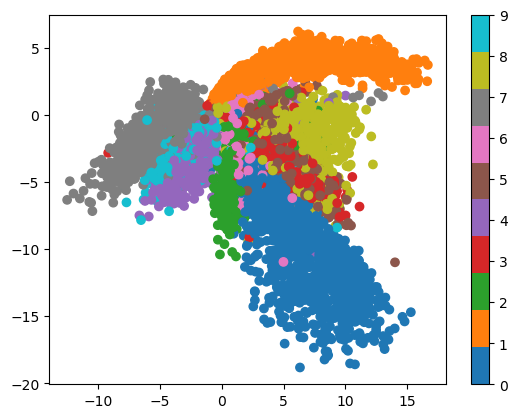

In [7]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
        
plot_latent(autoencoder, data)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

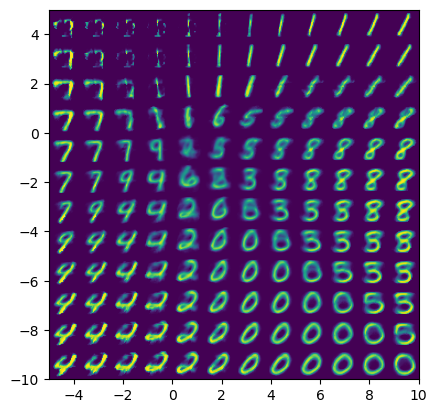

In [8]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    
plot_reconstructed(autoencoder)

We intentionally plot the reconstructed latent vectors using approximately the same range of values taken on by the actual latent vectors. We can see that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space. 

We can see that there are "gaps" in the latent space, where data is never mapped to. This becomes a problem when we try to use autoencoders as **generative models**. 

The goal of generative models is to take a data set $X$ and produce more data points from the same distribution that $X$ is drawn from. For autoencoders, this means sampling latent vectors $z \sim Z$ and then decoding the latent vectors to produce images. If we sample a latent vector from a region in the latent space that was never seen by the decoder during training, the output might not make any sense at all.

# Variational Autoencoders

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem.

In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result. 

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

![variational autoencoder](nb-assets/variational-autoencoder.png)

However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

This expression applies to two univariate Gaussian distributions (the full expression for two arbitrary univariate Gaussians is derived in [this math.stackexchange post](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)). Extending it to our diagonal Gaussian distributions is not difficult; we simply sum the KL divergence for each dimension.

This loss is useful for two reasons. First, we cannot train the encoder network by gradient descent without it, since gradients cannot flow through sampling (which is a non-differentiable operation). Second, by penalizing the KL divergence in this manner, we can encourage the latent vectors to occupy a more centralized and uniform location. In essence, we force the encoder to find latent vectors that approximately follow a standard Gaussian distribution that the decoder can then effectively decode.

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [9]:
INITAL_DIMS = 784 # 28 * 28 (MNIST image size)
HIDDEN_DIMS = 512 # hidden layer size

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(INITAL_DIMS, HIDDEN_DIMS)
        self.linear2 = nn.Linear(HIDDEN_DIMS, latent_dims)
        self.linear3 = nn.Linear(HIDDEN_DIMS, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### Train

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

In [10]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [11]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

Let's plot the latent vector representations of a few batches of data.

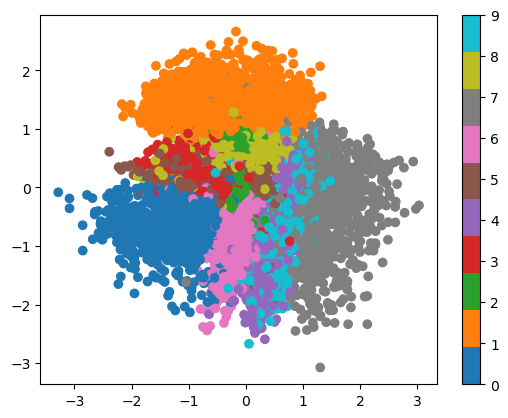

In [12]:
plot_latent(vae, data)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

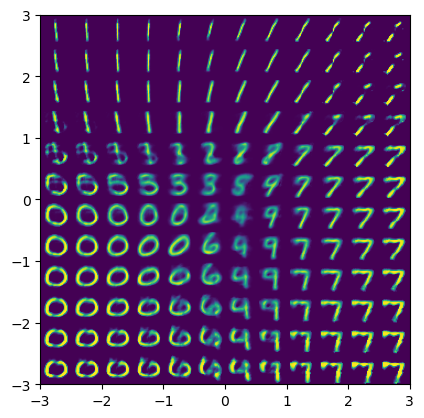

In [13]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)